In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
m = 1
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

In [43]:
class Reference_wave_generator:
    def __init__(self, lam, z0, dx0, auto_scaling=False):
        self.lam = lam
        self.z0 = z0
        self.dx0 = dx0
        self.auto_scaling = auto_scaling
    
    def plane_wave(self, shape, theta=0):
        N = shape[0]
        if self.auto_scaling:
            Lx0 = np.sqrt(self.lam * self.z0 * N)  # The object light field width that satisfies both amplitude and phase sampling conditions during FFT calculation
            dx0 = Lx0 / N
        else:
            dx0 = self.dx0
        ##
        dx1 = self.lam*self.z0/N/dx0
        x1p = dx1 * np.arange(-N//2, N//2)
        y1q = dx0 * np.arange(-N//2, N//2)
        X1p, Y1p = np.meshgrid(x1p, y1q)
        
        reference_wave = np.zeros(shape, dtype=np.complex128)
        reference_wave = np.exp(1j * 2 * np.pi / self.lam * np.sin(theta) * X1p)
        return reference_wave
    
    def spherical_wave(self, shape):
        N = shape[0]
        if self.auto_scaling:
            Lx0 = np.sqrt(self.lam * self.z0 * N)  # The object light field width that satisfies both amplitude and phase sampling conditions during FFT calculation
            dx0 = Lx0 / N
        else:
            dx0 = self.dx0
        ##
        dx1 = self.lam*self.z0/N/dx0
        x1p = dx1 * np.arange(-N//2, N//2)
        y1q = dx0 * np.arange(-N//2, N//2)
        X1p, Y1q = np.meshgrid(x1p, y1q)
        
        reference_wave = np.zeros(shape, dtype=np.complex128)
        reference_wave = np.exp(1j * np.pi * (X1p**2 + Y1q**2) / (self.lam * self.z0))
        return reference_wave

class Fresnel_propagator:
    def __init__(self, lam, dx0, z0, auto_scaling=False):
        self.lam = lam
        self.dx0 = dx0
        self.z0 = z0
        self.auto_scaling = auto_scaling
        pass
    
    def propagation_pq(self, image):
        lam = self.lam
        z0 = self.z0
        M, N = image.shape[0], image.shape[1]
        
        if self.auto_scaling:
            Lx0 = np.sqrt(self.lam * self.z0 * N)  # The object light field width that satisfies both amplitude and phase sampling conditions during FFT calculation
            dx0 = Lx0 / N
        else:
            dx0 = self.dx0
            
        if M!=N:
            raise ValueError("Input image must have the same height and width")

        # before fourier transform
        x0m = dx0 * np.arange(-N//2, N//2)
        y0n = dx0 * np.arange(-N//2, N//2)
        X0m, Y0n = np.meshgrid(x0m, y0n)
        
        phase_0 = np.exp(1j * (np.pi/lam/z0) * (X0m**2 + Y0n**2))
        f_mn = image * phase_0
        F_pq = np.fft.fftshift(np.fft.fft2(f_mn))
        
        # after fourier transform
        x1p = (lam*z0/M/dx0) * np.arange(-N//2, N//2)
        y1q = (lam*z0/N/dx0) * np.arange(-N//2, N//2)
        X1p, Y1q = np.meshgrid(x1p, y1q)
        
        phase_1 = np.exp(1j * 2 * np.pi * z0 / lam) * np.exp(1j*(np.pi/lam/z0) * (X1p**2 + Y1q**2))
        h_pq = (1/1j/lam/z0) * phase_1 * F_pq
        h_pq = h_pq * dx0 * dx0
        
        return h_pq
            

class Holography:
    def __init__(self, lam=633e-9, dx0=3.5e-6, z0 = 1.5, z1=1.5, reference_wave_form='plane', auto_scaling=False):
        self.lam = lam
        self.dx0 = dx0
        self.z0 = z0
        self.z1 = z1
        self.reference_wave_form = reference_wave_form
        self.auto_scaling = auto_scaling
        self.reference_wave_generator = Reference_wave_generator(self.lam, self.z0, self.dx0, self.auto_scaling)
        
    
    def pad_image(self, image):
        h, w = image.shape
        new_h = max(2**(int(np.log2(h))+1), 2**(int(np.log2(w))+1))
        new_w = new_h
        shift_h, shift_w = (new_h-h)//2, (new_w-w)//2
        
        padded_image = np.zeros((new_h, new_w))
        padded_image[0:h, 0:w] = image
        padded_image = np.roll(padded_image, shift=shift_h, axis=0)
        padded_image = np.roll(padded_image, shift=shift_w, axis=1)
        
        padded_image = padded_image / np.sum(padded_image) * new_h * new_w
        return padded_image

    def record(self, image, propagation_method='fresnel'):
        if propagation_method.lower()=='fresnel':
            propagator = Fresnel_propagator(self.lam, self.dx0, self.z0, self.auto_scaling)
            h_pq = propagator.propagation_pq(image)
        else:
            raise NotImplementedError("Only Fresnel method is supported currently")
        
        if self.reference_wave_form.lower()=='plane':
            reference_wave = self.reference_wave_generator.plane_wave(image.shape, theta=np.pi/10)
            holo = h_pq + reference_wave
        elif self.reference_wave_form.lower()=='spherical':
            reference_wave = self.reference_wave_generator.spherical_wave(image.shape)
            holo = h_pq + reference_wave
        else:
            raise NotImplementedError('Only plane wave and spherical wave is supported currently')
        return holo

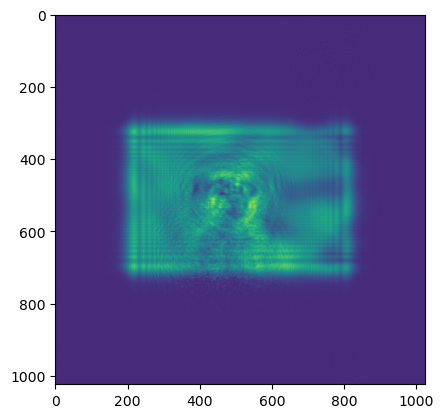

In [48]:
holography = Holography(lam=633*nm, dx0=3.5*um, z0=1.5*m, reference_wave_form='plane', auto_scaling=True)
a = Image.open('animal.jpg').convert('L')
a = np.array(a)
a = holography.pad_image(a)
holo = holography.record(a, 'fresnel')
plt.imshow(np.abs(holo))

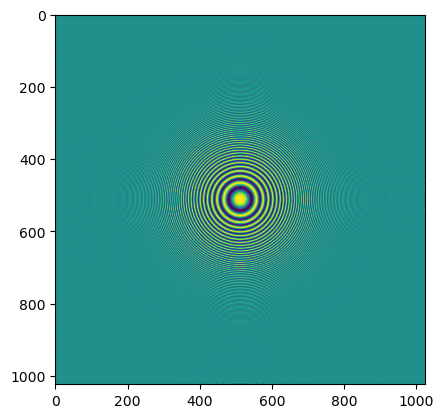

In [47]:
spherical = holography.reference_wave_generator.spherical_wave((1024, 1024))
plt.imshow(np.real(spherical))